In this project, we construct a Deep Neural Network (DNN) with the following specifications: 

- Code written from scratch e.g. no use of Keras / tensor flow etc
- The function will accept any number of hidden layers and hidden units at each layer
- L2 weight regularization is applied if indicated in the parameters
- We test our DNN's performance on the MINST dataset


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# **MINST (Sample Dataset)**



In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [6]:
def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

In [7]:
def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)

### Data preprocessing involves:
#### 1- One-hot encoding of the output variables
#### 2- Reshaping the 28*28 matrix to 1-D 784 vectors
#### 3- Data is normalized e.g. substraction of mean and division by standard deviation

In [8]:
enc=OneHotEncoder(sparse=False)
y_train=enc.fit_transform(y_train.reshape(len(y_train),1))
y_test=enc.fit_transform(y_test.reshape(len(y_test),1))

In [9]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1]**2) # Convert array from 2D to 1D
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1]**2)

In [10]:
#Normalize the train and test data
X_train=(X_train-X_train.mean())/ X_train.std()
X_test=(X_test-X_test.mean())/ X_test.std()

### The below function is meant to generate weight and bias as per the hidden layers configuration

In [11]:
def generate_matrices_bias(X, y, l_hidden):
    W_x=[] 
    B_x=[]
    K=y.shape[1]
            
    W_x.append(np.random.normal(0,0.02,((X.shape[1], l_hidden[0])))) # Accounts for the first hidden layer
    B_x.append(np.random.normal(0,0.02,(1, l_hidden[0])))
            
    if len(l_hidden)>1:
        for i in range(len(l_hidden)-1):
            
            W_x.append(np.random.normal(0,0.02,((l_hidden[i], l_hidden[i+1])))) # Takes care of intermediate hidden layer
            B_x.append(np.random.normal(0,0.02,(1, l_hidden[i+1])))
            
    W_x.append(np.random.normal(0,0.02,((l_hidden[-1], K)))) # Takes care of the output layer weights with K being number of classes
    B_x.append(np.random.normal(0,0.02,(1, K)))

        
    W_x=np.array(W_x, dtype='object')
    #B_x=np.array(B_x, dtype='object')

    return W_x, B_x

### The forward pass and model_accuracy functions are used for computing accurace of the model

In [12]:
def forward_pass(X, W_x, B_x):
    Z_h=[]
        
    h=(X@W_x[0])+B_x[0]
    Zh= sigmoid(h)
    Z_h.append(Zh)
    #print('Zh', Z_h[-1].shape)
    if len(W_x)>2:
        
        for i in range(len(W_x)-2):
            
            #print('intermediate')
            h_intermediate= (Z_h[i]@W_x[i+1])+B_x[i+1]
            Zh_intermediate= sigmoid(h_intermediate)
            Z_h.append(Zh_intermediate)
            #print('intermediate', Zh_intermediate.shape)
    Aout= (Z_h[-1]@W_x[-1])+B_x[-1]
    #print('Aout', Aout.shape)
    Zout= softmax(Aout)
        
    return Zout

In [13]:
# Utility function to compute model's accuracy
def model_accuracy(y_hat, y_train):
    ctr=0
    for i in range(len(y_hat)):
        if np.argmax(y_hat[i])==np.argmax(y_train[i]):
            ctr+=1
    return round((ctr*100/len(y_hat)),2)

### This is the main Neural Netwrok function

In [14]:
def Neural_Network(X_train, y_train, X_test, y_test, hidden_layers, lr=0.0001, epochs=100, l2_lambda=0):
    training_accuracy=[]
    validation_accuracy=[]
    validation_cost=[]
    W_x, B_x= generate_matrices_bias(X_train, y_train, hidden_layers) # Utility function to initiate weight and bias matrices as per the hidded layers configuration
    cost=[]   # List of Cost for plotting purposes
    for i in range(epochs):
        
        Z_h=[] # Zh values are stored in a list to enable forward-pass and backward-propagaation thru multiple hidden layers
        
        #Forward pass
        
        for j in range(len(W_x)): 
                
            # Input layer
            if j==0: 
                Zh1=(X_train@W_x[j])+B_x[j] # Zh1=[X.Wh1]+bh1
                ah1= sigmoid(Zh1)
                Z_h.append(ah1)
             
            # Output layer
            elif j==len(W_x)-1:

                A_out= (Z_h[j-1]@W_x[j])+B_x[j]
                #Z_h.append(A_out)
                y= softmax(A_out)
                #print('output layer', y[:10,:1], 'j=', j)
                
            # Hidden layers
            else :
                Zh_intermediate= (Z_h[j-1]@W_x[j])+B_x[j]
                Ah_intermediate= sigmoid(Zh_intermediate)
                Z_h.append(Ah_intermediate)
                #print('hidden layer', j, Ah_intermediate[:10,:1])

        # Backward-propagation
        
        for j in range(len(W_x)-1, -1, -1):
            #print('backpop',j)
            if j==len(W_x)-1:
                #print('backprop output',j)
                # Backprop for output layer
                log_loss=(y-y_train)
                l2_penalty=0
                    
                cost.append(-np.sum(y_train*np.log(y)/len(y)))# +((l2_lambda/2*len(y))*np.linal.norm(W_x[-1])**2)) # Cross Entropy cost with L2 regularization | Loss + lambda/2m * sum of ||w||**2
                W_x[j]=(1-(lr*l2_lambda/len(X_train)))*W_x[j]-lr*(Z_h[-1].T@log_loss)
                B_x[j]=(1-(lr*l2_lambda/len(X_train)))*B_x[j]-lr*np.sum(log_loss, axis=0)
                #print('output layer done')
                
            # Input layer    
            elif j==0: 
                #print('backprop input layer', j)
                log_loss= (log_loss@W_x[j+1].T)*sigmoid_prime(Z_h[0])
                W_x[j]=(1-(0.01*l2_lambda/len(X_train)))*W_x[j]-lr*(X_train.T@log_loss) # Weight and bias updates with L2 regularization. Lambda is zero unless indicated
                B_x[j]=(1-(0.01*l2_lambda/len(X_train)))*B_x[j]-lr*np.sum(log_loss, axis=0)
                #print('input layer done')
            
            # Hidden layers
            else:
                #print('backprop hidden',j)
                #print('Hidden layer')
                log_loss= (log_loss@W_x[j+1].T)*sigmoid_prime(Z_h[j])
                W_x[j]-=lr*(Z_h[j-1].T@log_loss)
                B_x[j]-=lr*np.sum(log_loss, axis=0)
                #print(i, 'intermediate')
                
        # Model metrics - Training & Validation costs / accuracies 
        
        y_hat_test=forward_pass(X_test, W_x, B_x)
        training_accuracy.append(model_accuracy(y, y_train))
        validation_accuracy.append(model_accuracy(y_hat_test, y_test))
        validation_cost.append(-np.sum(y_test*np.log(y_hat_test)/len(X_test)))
        if i%100==0: # print results every 20 epochs
            y_hat_train=forward_pass(X_train, W_x, B_x) 
            y_hat_test=forward_pass(X_test, W_x, B_x)
            print('**** Epoch ', i+1, '/', epochs, '****')
            print('Training accuracy:', model_accuracy(y_hat_train, y_train),'%')
            print('Validation accuracy',model_accuracy(y_hat_test, y_test),'%')
    print('Model training completed!')        
    print('Training Accuracy:', training_accuracy[-1],'%')
    print('Validation Accuracy:', validation_accuracy[-1],'%')
    return cost, W_x, B_x, y, training_accuracy, validation_accuracy, validation_cost

### The parameters of the function are set below

In [146]:
l_hidden=[128,64] # Hidden layers configuration
alpha=0.00001 # Learning rate
l2_lambda=0.2 #L2 regularization variable
epochs=1000 # Number of epochs

### We run three expirements with a combination of hyper-parameters

In [147]:
error, W_x, B_x, y, training_acc, val_acc, val_cost=Neural_Network(X_train, y_train, X_test, y_test, l_hidden, alpha, epochs, l2_lambda)

**** Epoch  1 / 1000 ****
Training accuracy: 11.24 %
Validation accuracy 11.35 %
**** Epoch  101 / 1000 ****
Training accuracy: 38.04 %
Validation accuracy 37.96 %
**** Epoch  201 / 1000 ****
Training accuracy: 72.06 %
Validation accuracy 73.02 %
**** Epoch  301 / 1000 ****
Training accuracy: 79.14 %
Validation accuracy 80.04 %
**** Epoch  401 / 1000 ****
Training accuracy: 82.52 %
Validation accuracy 82.83 %
**** Epoch  501 / 1000 ****
Training accuracy: 85.29 %
Validation accuracy 85.63 %
**** Epoch  601 / 1000 ****
Training accuracy: 86.8 %
Validation accuracy 87.1 %
**** Epoch  701 / 1000 ****
Training accuracy: 87.66 %
Validation accuracy 87.79 %
**** Epoch  801 / 1000 ****
Training accuracy: 88.26 %
Validation accuracy 88.41 %
**** Epoch  901 / 1000 ****
Training accuracy: 88.72 %
Validation accuracy 88.92 %


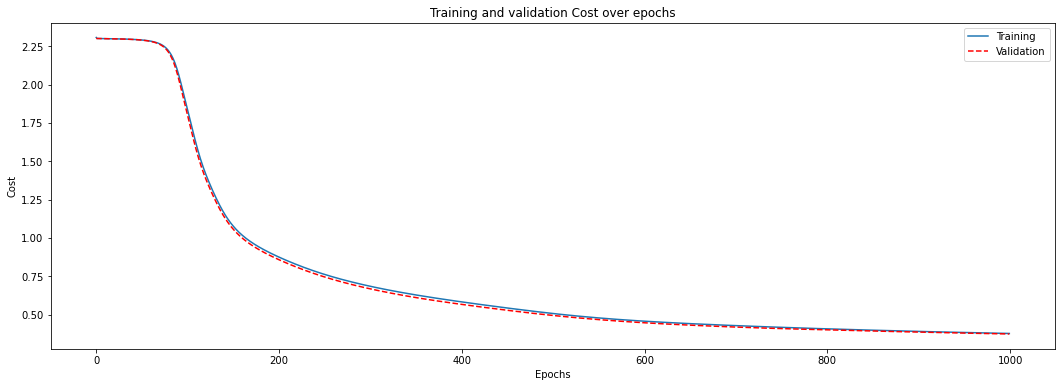

In [152]:
plt.figure(figsize=(18,6))
plt.plot(error, label='Training')
plt.plot(val_cost, '--', color='red' , label='Validation')
plt.title('Training and validation Cost over epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

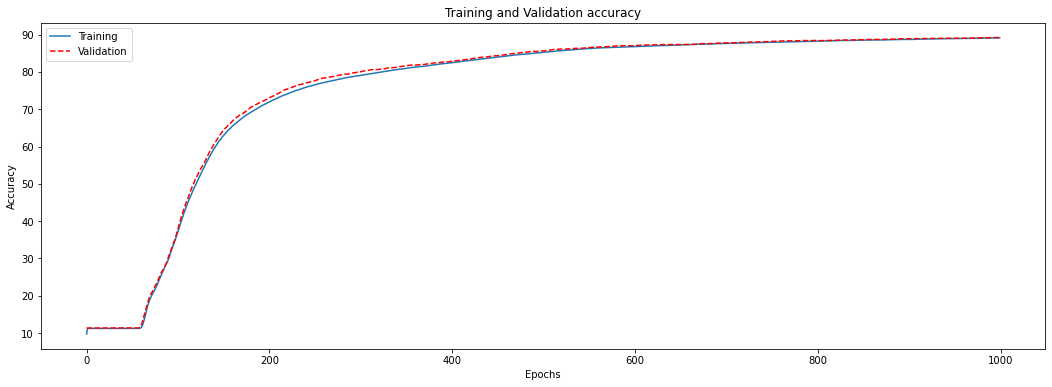

In [153]:
plt.figure(figsize=(18,6))
plt.plot(training_acc, label='Training')
plt.plot(val_acc, '--',color='red', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### The model has two hidden layers (128,64) with $\lambda$ =0.2 and $\alpha$=1e-4 resulted in a validation accuracy of ~89%

In [326]:
l_hidden=[100] # Hidden layers configuration
alpha=0.00001 # Learning rate
l2_lambda=0.2 #L2 regularization variable
epochs=10000 # Number of epochs

In [327]:
error, W_x, B_x, y, training_acc, val_acc, val_cost=Neural_Network(X_train, y_train, X_test, y_test, l_hidden, alpha, epochs, l2_lambda)

**** Epoch  1 / 10000 ****
Training accuracy: 26.17 %
Validation accuracy 26.45 %
**** Epoch  101 / 10000 ****
Training accuracy: 89.16 %
Validation accuracy 89.51 %
**** Epoch  201 / 10000 ****
Training accuracy: 90.31 %
Validation accuracy 90.58 %
**** Epoch  301 / 10000 ****
Training accuracy: 90.72 %
Validation accuracy 90.96 %
**** Epoch  401 / 10000 ****
Training accuracy: 90.94 %
Validation accuracy 91.22 %
**** Epoch  501 / 10000 ****
Training accuracy: 91.16 %
Validation accuracy 91.35 %
**** Epoch  601 / 10000 ****
Training accuracy: 91.28 %
Validation accuracy 91.46 %
**** Epoch  701 / 10000 ****
Training accuracy: 91.39 %
Validation accuracy 91.48 %
**** Epoch  801 / 10000 ****
Training accuracy: 91.46 %
Validation accuracy 91.45 %
**** Epoch  901 / 10000 ****
Training accuracy: 91.56 %
Validation accuracy 91.61 %
**** Epoch  1001 / 10000 ****
Training accuracy: 91.61 %
Validation accuracy 91.58 %
**** Epoch  1101 / 10000 ****
Training accuracy: 91.67 %
Validation accuracy 

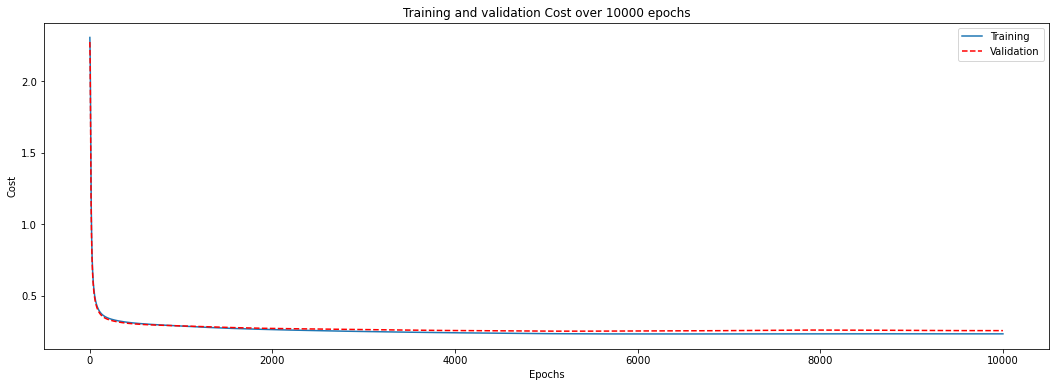

In [328]:
plt.figure(figsize=(18,6))
plt.plot(error, label='Training')
plt.plot(val_cost, '--', color='red' , label='Validation')
plt.title('Training and validation Cost over ' + str(epochs)+' epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

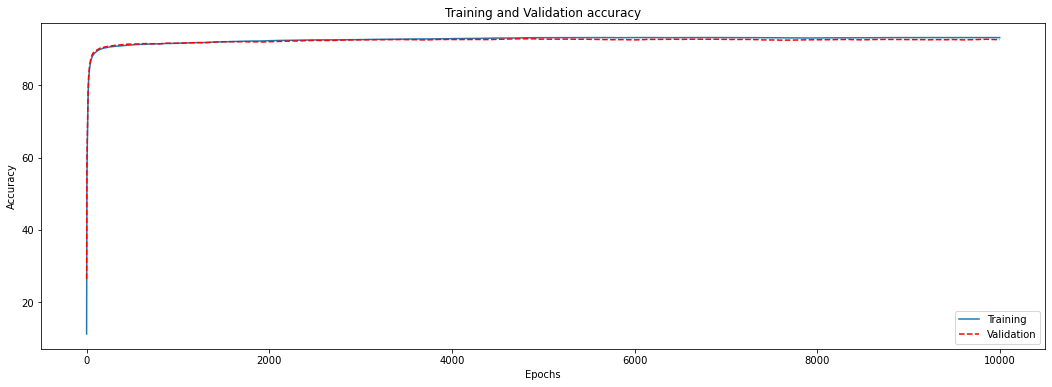

In [329]:
plt.figure(figsize=(18,6))
plt.plot(training_acc, label='Training')
plt.plot(val_acc, '--',color='red', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### The model has one hidden layer with 100 units with $\lambda$ =0.2 and $\alpha$=1e-4 resulted in a validation accuracy of ~92%

In [313]:
l_hidden=[32] # Hidden layers configuration
alpha=0.00001 # Learning rate
l2_lambda=0.1 #L2 regularization variable
epochs=1000 # Number of epochs

In [314]:
error, W_x, B_x, y, training_acc, val_acc, val_cost=Neural_Network(X_train, y_train, X_test, y_test, l_hidden, alpha, epochs, l2_lambda)

**** Epoch  1 / 1000 ****
Training accuracy: 13.83 %
Validation accuracy 13.85 %
**** Epoch  101 / 1000 ****
Training accuracy: 82.69 %
Validation accuracy 83.66 %
**** Epoch  201 / 1000 ****
Training accuracy: 85.51 %
Validation accuracy 85.93 %
**** Epoch  301 / 1000 ****
Training accuracy: 86.54 %
Validation accuracy 87.07 %
**** Epoch  401 / 1000 ****
Training accuracy: 87.33 %
Validation accuracy 87.59 %
**** Epoch  501 / 1000 ****
Training accuracy: 87.86 %
Validation accuracy 88.15 %
**** Epoch  601 / 1000 ****
Training accuracy: 88.22 %
Validation accuracy 88.49 %
**** Epoch  701 / 1000 ****
Training accuracy: 88.54 %
Validation accuracy 88.75 %
**** Epoch  801 / 1000 ****
Training accuracy: 88.78 %
Validation accuracy 88.79 %
**** Epoch  901 / 1000 ****
Training accuracy: 89.02 %
Validation accuracy 89.11 %
Model training completed!
Training Accuracy: 89.13 %
Validation Accuracy: 89.21 %


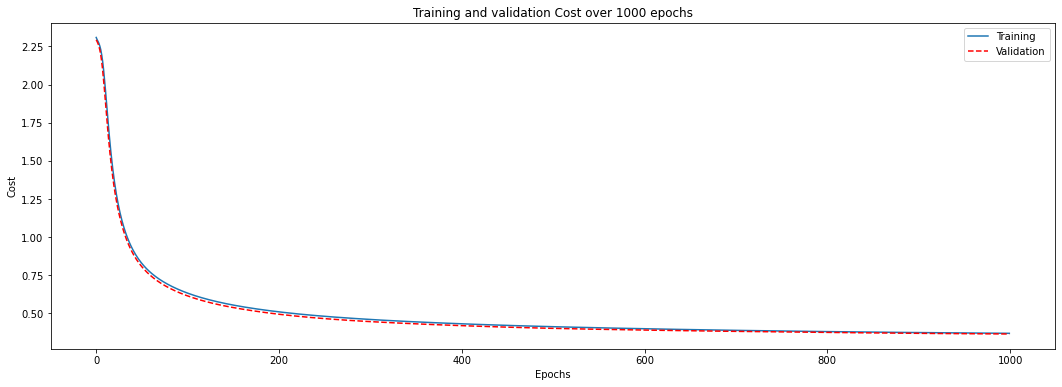

In [315]:
plt.figure(figsize=(18,6))
plt.plot(error, label='Training')
plt.plot(val_cost, '--', color='red' , label='Validation')
plt.title('Training and validation Cost over ' + str(epochs)+' epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

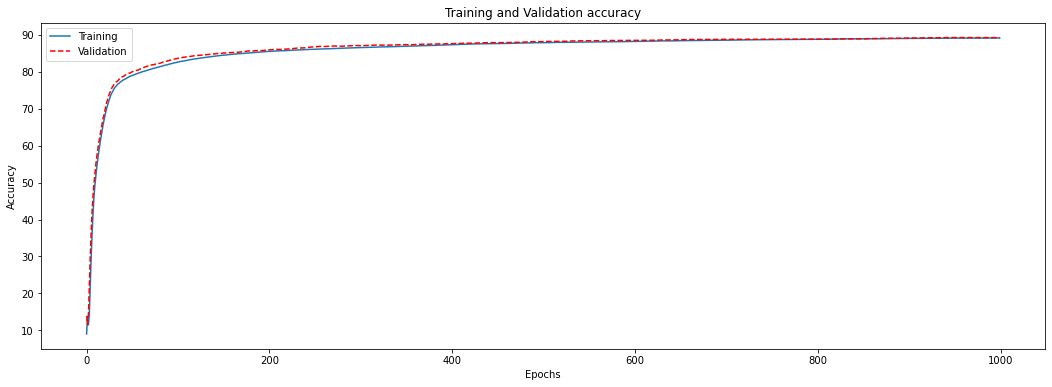

In [316]:
plt.figure(figsize=(18,6))
plt.plot(training_acc, label='Training')
plt.plot(val_acc, '--',color='red', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### The model has one hidden layer with 32 units with $\lambda$ =0.1 and $\alpha$=1e-4 resulted in a validation accuracy of ~89%

In [38]:
l_hidden=[64,64] # Hidden layers configuration
alpha=0.00001 # Learning rate
l2_lambda=0.2 #L2 regularization variable
epochs=800 # Number of epochs

In [39]:
error, W_x, B_x, y, training_acc, val_acc, val_cost=Neural_Network(X_train, y_train, X_test, y_test, l_hidden, alpha, epochs, l2_lambda)

**** Epoch  1 / 800 ****
Training accuracy: 11.24 %
Validation accuracy 11.35 %
**** Epoch  101 / 800 ****
Training accuracy: 21.36 %
Validation accuracy 21.49 %
**** Epoch  201 / 800 ****
Training accuracy: 62.34 %
Validation accuracy 62.88 %
**** Epoch  301 / 800 ****
Training accuracy: 73.06 %
Validation accuracy 73.78 %
**** Epoch  401 / 800 ****
Training accuracy: 76.36 %
Validation accuracy 77.03 %
**** Epoch  501 / 800 ****
Training accuracy: 78.52 %
Validation accuracy 79.03 %
**** Epoch  601 / 800 ****
Training accuracy: 80.75 %
Validation accuracy 80.97 %
**** Epoch  701 / 800 ****
Training accuracy: 83.43 %
Validation accuracy 83.35 %
Model training completed!
Training Accuracy: 85.04 %
Validation Accuracy: 85.14 %


In [ ]:
plt.figure(figsize=(18,6))
plt.plot(error, label='Training')
plt.plot(val_cost, '--', color='red' , label='Validation')
plt.title('Training and validation Cost over ' + str(epochs)+' epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(training_acc, label='Training')
plt.plot(val_acc, '--',color='red', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### The last expirement with four hidden layers demonstrated no learning whatsoever for the model.

###  Conclusion

#### For variable configurations have been trialed in this expirement. All expirements ran for 1K epochs for each model with variable configurations for hidden layers and L2-regularization $\lambda$ values. The $\alpha$ value was fixed at 1e-4 for all trials. It was noted that the best performance was attributed to experiment No.2 with one hidden layer with one hidden node, which procuded a validation accuracy rate of 92%. The model produced a validation accuracy of >90 just after 200 epochs.

#### More complex models like the one in the first expirement took much longer to improve accuracy and only reached 89% accuracy after 1000 epochs. It is also notable that the model's accuracy was under 20% for almost 70 epochs before starting to improve. Other expirements not mentioned in the notebook with higher numbers of nodes like 256, resulted in poor accuracies and severe over-fitting.

#### Moreover, L2 regularization had a marginal effect on the results, this might have been attributed to the little amount of noise in the dataset, which was relatively easy to learn for the models.

#### Very complex configurations like trial No.4 with 4 hidden layers was stuck at 11% accuracy and did not manage to learn the dataset. One more important note is the $\alpha$ value was tested throughly and was kept low at 1e-4 for the models to learn. Any higher value was detremental to the model and no learning was produced with higher values.

#### Finally, both training and validations costs and accuracies were very close to each other, which meant that the models were generalizing very well and no overfitting was happening. Despite being a black-box, model complexity should be adapted to the data complexity, and in this case, a 1-hidden layer model is more than enough to provide good results for the MINST dataset. Further epochs may have increased accuracy to closer to 96% or 97%.
